# Comparison of hourly spot values #
Possible installation issues are first verified by comparing modules y_cln against hrly PoA irradiance spot measurements.
1. *obstimestamp* is the start of the I-V measurement
1. *iv_sweep_endtime* is the time the I-V measurement sweep was completed (takes a few seconds)

The I-V curves are measured by separate loads for each module, so not necessarily synchronised.
Thus for each hr, the first *iv_sweep_endtime* is selected
and that is joined with the corresponding hrly irradiance measurement.

Due to memory restrictions found in SQL manager (see later), only 2019 data were evaluated.
Data were also imported separately for each module as csv file before merging them.
**SQL manager memory error**
~~~~postgresql
ERROR:  out of memory
DETAIL:  Failed on request of size 12201600.
(execution time: 00:18:37; total time: 00:18:38)
~~~~

In [1]:
%store -r

In [ ]:
#import libraries
import os
import pandas as pd
#importin heatmap from seaborn
from seaborn import heatmap
#importing triu for triangular
from numpy import triu, datetime64
#enabling visualisation in matplotlib
%matplotlib inline
# module for connecting to CREST db1
import database_operations as db
# module for operation on dataset
import data_operations as mc
# for str search
import re

ISC_IRRADIANCE_FILES_FOLDER = os.path.join(os.path.dirname(os.getcwd())+r"/assets/isc_irradiance_files/")

## Hourly spot values evaluation ##
First files are merged together.

In [2]:
df = mc.merge_datetime_csvs(csvs_folderpath=ISC_IRRADIANCE_FILES_FOLDER,
                            columns_to_exclude=['pt1000_ppuk_sensol'],
                         datetime_column= "date_trunc")

ch1.csv adding columns: isc_1,mt1_1,mt2_1,iv_sweep_endtime_1,channelnumber_1,date_trunc
ch10.csv adding columns: isc_10,mt1_10,mt2_10,iv_sweep_endtime_10,channelnumber_10,date_trunc
ch11.csv adding columns: isc_11,mt1_11,mt2_11,iv_sweep_endtime_11,channelnumber_11,date_trunc
ch12.csv adding columns: isc_12,mt1_12,mt2_12,iv_sweep_endtime_12,channelnumber_12,date_trunc
ch13.csv adding columns: isc_13,mt1_13,mt2_13,iv_sweep_endtime_13,channelnumber_13,date_trunc
ch14.csv adding columns: isc_14,mt1_14,mt2_14,iv_sweep_endtime_14,channelnumber_14,date_trunc
ch2.csv adding columns: isc_2,mt1_2,mt2_2,iv_sweep_endtime_2,channelnumber_2,date_trunc
ch3.csv adding columns: isc_3,mt1_3,mt2_3,iv_sweep_endtime_3,channelnumber_3,date_trunc
ch4.csv adding columns: isc_4,mt1_4,mt2_4,iv_sweep_endtime_4,channelnumber_4,date_trunc
ch6.csv adding columns: isc_6,mt1_6,mt2_6,iv_sweep_endtime_6,channelnumber_6,date_trunc
ch7.csv adding columns: isc_7,mt1_7,mt2_7,iv_sweep_endtime_7,channelnumber_7,date_trunc
ch

### Preliminary evaluation of correlation between the different measurements ###
For a first analysis only the short circuit current values and irradiance values are selected.

In [3]:
df_y_cln = df.copy(deep = True)
columns_to_drop = [c for c in df_y_cln.columns.tolist() if len(re.findall('mt|cha|tms|iv_sweep', c))>0]
df_y_cln.drop(columns=columns_to_drop, inplace=True)

Then the only the records for which PoA irradiance is higher than 0 are selected.
A first overview shows that short circuit current 1 and short circuit current 5 have respectively few and no data.
Since two modules per technology are installed, each in different positions,
short circuit current 1, short circuit current 2, short circuit current 5 and short circuit current 6 won't be further considered.

In [4]:
df_p = df_y_cln.copy(deep = True)
df_p = df_p.loc[df.g_cmp11_ppuk_gpoa>0]
df_p.describe()

,isc_1,isc_10,isc_11,isc_12,isc_13,isc_14,isc_2,isc_3,isc_4,isc_6,isc_7,isc_8,isc_9,g_cmp11_ppuk_poa,sensol_ppuk_rcell
count,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000,257.000000
mean,0.476949,0.339284,0.339226,0.343078,0.510848,0.517654,0.513708,0.506261,0.516798,0.494397,0.329027,0.319237,0.342829,56.186377,61.407191
std,1.695506,1.129252,1.122527,1.124268,1.694234,1.696235,1.659993,1.696150,1.702662,1.654021,1.088626,1.088621,1.130061,173.917395,202.583915
min,-0.015000,-0.001000,0.002000,0.005000,-0.001000,0.008000,0.006000,-0.003000,0.002000,-0.005000,0.000000,-0.008000,0.000000,0.114000,0.000000
25%,-0.015000,-0.001000,0.002000,0.005000,-0.001000,0.008000,0.009000,-0.003000,0.002000,-0.005000,0.000000,-0.008000,0.000000,0.682000,0.000000
50%,-0.015000,-0.001000,0.002000,0.005000,-0.001000,0.008000,0.009000,-0.003000,0.002000,-0.005000,0.000000,-0.008000,0.000000,4.318000,0.084000
75%,-0.010000,0.009000,0.016000,0.013000,0.025000,0.019000,0.038000,0.010000,0.025000,0.017000,0.009000,0.000000,0.019000,16.364000,3.395000
max,10.511000,6.000000,6.009000,6.011000,9.005000,9.046000,8.814000,9.012000,9.041000,8.779000,5.794000,5.775000,6.011000,1071.591000,1073.277000


Statistical parameters seem to suggest an high correlation between the irradiance sensors and some modules.
This is further verified by extract a Pearson correlation matrix.
y_cln1, y_cln2, y_cln5 and y_cln6 are excluded for a better visualisation.
Found correlation for positive values of irradiance is higher than 0.99.

In [5]:
y_cln_excluded = ['isc_1', 'isc_2', 'isc_5', 'isc_6']
y_cln_selection = [c for c in df_p.columns if c not in y_cln_excluded]
df_p_corr = df_p.loc[:,y_cln_selection].corr()

<AxesSubplot:>

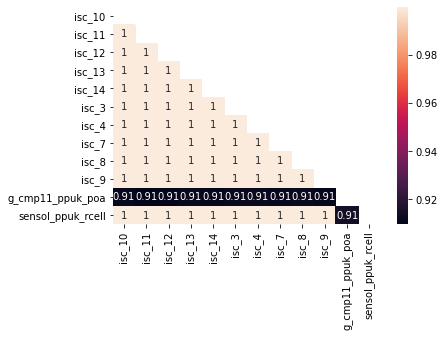

In [6]:
mask = triu(df_p_corr)
heatmap(df_p_corr, annot=True, mask=mask)

Interactions could be better appreciated by looking at interactions generated
through a complete preliminary analysis (not required).

In [ ]:
# optional profiling (preliminary analysis) not necessary
# from pandas_profiling import ProfileReport
# profile = ProfileReport(df_y_cln, title='Pandas Profiling Report')
# profile.to_widgets()

### Evaluation of min and max values for PoA measurements ###
For each day, the datetimes corresponding to the to when the sensor, oriented to-wards the equator,
receives the first and last ray of sun based on sun path and irradiance peak,
as well the datetime corresponding to the maximum value, are extracted.
Datetimes of first and last minimum measurements are also extracted.

**SQL queries**
<br>
For PoA and reference cell measuremets:
```postgresql
SELECT DISTINCT ON(date_trunc('hr', i.tmstamp)) i.sensol_ppuk,
i.tmstamp, date_trunc('hr', i.tmstamp) as date_trunc
FROM w_meas.mms1_cr1000_tom as i WHERE
i.tmstamp >= '01/01/2019  00:00:00'
AND i.tmstamp < '01/01/2020  00:00:00'
ORDER BY date_trunc('hr', i.tmstamp), i.tmstamp
```

In [7]:
# loading poa only for testing (without merging csv)
df_gpoa, errors = mc.csv_read_datetime_format(filepath=os.path.join(ISC_IRRADIANCE_FILES_FOLDER,'chpoa_y19.csv'),
                                     datetime_column="date_trunc")

gpoa_daily = mc.get_min_max_by_date(values= pd.Series(df_gpoa.g_cmp11_ppuk.values, index = df_gpoa.date_trunc.values),
                                    parameter="poa")